In [39]:
import numpy as np 
import pickle
%matplotlib inline 
import matplotlib 
from matplotlib import pyplot as plt

In [40]:
from kerasAC.vis import * 
def plot_seq_importance(vals_to_plot, xlim=None, ylim=None, figsize=(25, 3),title="",snp_pos=0,axes=None):
    """Plot  sequence importance score                                                                                                                                                                                                                                                                             
                                                                                                                                                                                                                                                                                                                   
    Args:                                                                                                                                                                                                                                                                                                          
      grads: either deeplift or gradientxinput score matrix                                                                                                                                                                                                                                                        
      x: one-hot encoded DNA sequence                                                                                                                                                                                                                                                                              
      xlim: restrict the plotted xrange                                                                                                                                                                                                                                                                            
      figsize: matplotlib figure size                                                                                                                                                                                                                                                                              
    """
    if axes is None:
        f,axes=plt.subplots(1,dpi=80,figsize=figsize)
        show=True
    else:
        show=False

    seq_len = vals_to_plot.shape[0]
    if xlim is None:
        xlim = (0, seq_len)
    if ylim is None:
        ylim= (np.amin(vals_to_plot),np.amax(vals_to_plot))
    axes=plot_bases_on_ax(vals_to_plot,axes,show_ticks=True)
    plt.xticks(list(range(xlim[0], xlim[1], 5)))
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    axes.set_title(title)
    axes.axvline(x=snp_pos, color='k', linestyle='--')
    if show==True:
        plt.show()
    else:
        return axes


# Prior KMER biases (Ohler, Vierstra, Tobias)

In [41]:
## dnase, tobias, K562
tobias_data_dnase_k562=pickle.load(open("/srv/scratch/annashch/bias_correction/enzymatic_bias/tobias/dnase/K562.filtered_AtacBias.pickle",'rb'))
#0
tobias_dnase_pssm_forward=np.transpose(tobias_data_dnase_k562.bias['forward'].pssm[0:4])[:,[0,2,3,1]]
#1
tobias_dnase_pssm_reverse=np.transpose(tobias_data_dnase_k562.bias['reverse'].pssm[0:4])[:,[0,2,3,1]]
tobias_dnase_pssm_summed=tobias_dnase_pssm_forward+tobias_dnase_pssm_reverse 


In [45]:
#dnase, ohler
#2
ohler_dnase_doublehit=np.loadtxt('/srv/scratch/annashch/bias_correction/enzymatic_bias/get_pwm_from_kmer/pwm.SeqBias_DNase_doublehit.txt').T
#3
ohler_dnase_singlehit=np.loadtxt('/srv/scratch/annashch/bias_correction/enzymatic_bias/get_pwm_from_kmer/pwm.SeqBias_DNase_singlehit.txt').T
#4
vierstra_dnase=np.loadtxt('/srv/scratch/annashch/bias_correction/enzymatic_bias/get_pwm_from_kmer/pwm.vierstra_et_al.6mer-model.txt').T


## BPNET PSSM 

In [69]:
## BPNET-derived PSSM -->  USE GM12878 because we have those peaks in both DNASE & ATAC 

#load pssm
dnase_gm12878_bpnet_pssm_6mer=np.transpose(np.loadtxt("/srv/scratch/annashch/bias_correction/enzymatic_bias/get_pwm_from_bpnet/pwm.dnase.k562.0.computed.6mer.center"))
dnase_gm12878_bpnet_pssm_24mer=np.transpose(np.loadtxt("/srv/scratch/annashch/bias_correction/enzymatic_bias/get_pwm_from_bpnet/pwm.dnase.k562.0.computed.24mer.center"))


In [85]:
## BPNET-derived PSSM for bpnet model with zero-counts loss 

#load pssm
dnase_gm12878_bpnet_pssm_6mer_zerocounts=np.transpose(np.loadtxt("/srv/scratch/annashch/bias_correction/enzymatic_bias/get_pwm_from_bpnet/zero_counts_loss/pwm.dnase.gm12878.0.computed.6mer.center"))
dnase_gm12878_bpnet_pssm_24mer_zerocounts=np.transpose(np.loadtxt("/srv/scratch/annashch/bias_correction/enzymatic_bias/get_pwm_from_bpnet/zero_counts_loss/pwm.dnase.gm12878.0.computed.24mer.center"))


## load models


In [86]:
from keras.models import load_model
from keras.utils.generic_utils import get_custom_objects
from kerasAC.metrics import * 
from kerasAC.custom_losses import * 
custom_objects={"recall":recall,
                    "sensitivity":recall,
                    "specificity":specificity,
                    "fpr":fpr,
                    "fnr":fnr,
                    "precision":precision,
                    "f1":f1,
                    "ambig_binary_crossentropy":ambig_binary_crossentropy,
                    "ambig_mean_absolute_error":ambig_mean_absolute_error,
                    "ambig_mean_squared_error":ambig_mean_squared_error,
                    "MultichannelMultinomialNLL":MultichannelMultinomialNLL}
get_custom_objects().update(custom_objects)


In [87]:
#Vierstra fixed, 6mer 
fixed_6mer_model=load_model("/srv/scratch/annashch/bias_correction/enzymatic_bias/profile_model_of_bias/fixed_filter/dnase/6mer/seed1234/bias.dnase.6mer.0.hdf5")
fixed_6mer_weights=fixed_6mer_model.layers[1].get_weights()[0].squeeze()

In [88]:
#Vierstra, trainable, 6mer 
trainable_6mer_model=load_model("/srv/scratch/annashch/bias_correction/enzymatic_bias/profile_model_of_bias/kmer_init_tuned/dnase/6mer/seed2345/bias.dnase.6mer.0.hdf5")
trainable_6mer_weights=trainable_6mer_model.layers[1].get_weights()[0].squeeze()

In [89]:
# 6mer random, 1 filter 
random_6mer_model=load_model("/srv/scratch/annashch/bias_correction/enzymatic_bias/profile_model_of_bias/6mer/dnase/1filter/seed1234/bias.dnase.6mer.0.hdf5")
random_6mer_weights=random_6mer_model.layers[1].get_weights()[0].squeeze()

In [90]:
#Tobias fixed, 24mer 
fixed_24mer_model=load_model("/srv/scratch/annashch/bias_correction/enzymatic_bias/profile_model_of_bias/fixed_filter/dnase/24mer/seed1234/bias.dnase.24mer.0.hdf5")
fixed_24mer_weights=fixed_24mer_model.layers[1].get_weights()[0].squeeze()

In [91]:
#TOBIAS, trainable, 24mer
trainable_24mer_model=load_model("/srv/scratch/annashch/bias_correction/enzymatic_bias/profile_model_of_bias/kmer_init_tuned/dnase/24mer/seed2345/bias.dnase.24mer.0.hdf5") 
trainable_24mer_weights=trainable_24mer_model.layers[1].get_weights()[0].squeeze()

In [92]:
# 24mer random 1 filter 
random_24mer_model=load_model("/srv/scratch/annashch/bias_correction/enzymatic_bias/profile_model_of_bias/24mer/dnase/1filter/seed1234/bias.dnase.24mer.0.hdf5")
random_24mer_weights=random_24mer_model.layers[1].get_weights()[0].squeeze()

In [93]:
#6mer random 5 filter
random_6mer_5filter_model=load_model("/srv/scratch/annashch/bias_correction/enzymatic_bias/profile_model_of_bias/6mer/dnase/seed1234/bias.dnase.6mer.0.hdf5")
random_6mer_5filter_weights=random_6mer_5filter_model.layers[1].get_weights()[0].squeeze() 

In [94]:
#24mer random 5 filter 
random_24mer_5filter_model=load_model("/srv/scratch/annashch/bias_correction/enzymatic_bias/profile_model_of_bias/24mer/dnase/seed1234/bias.dnase.24mer.0.hdf5")
random_24mer_5filter_weights=random_24mer_5filter_model.layers[1].get_weights()[0].squeeze() 

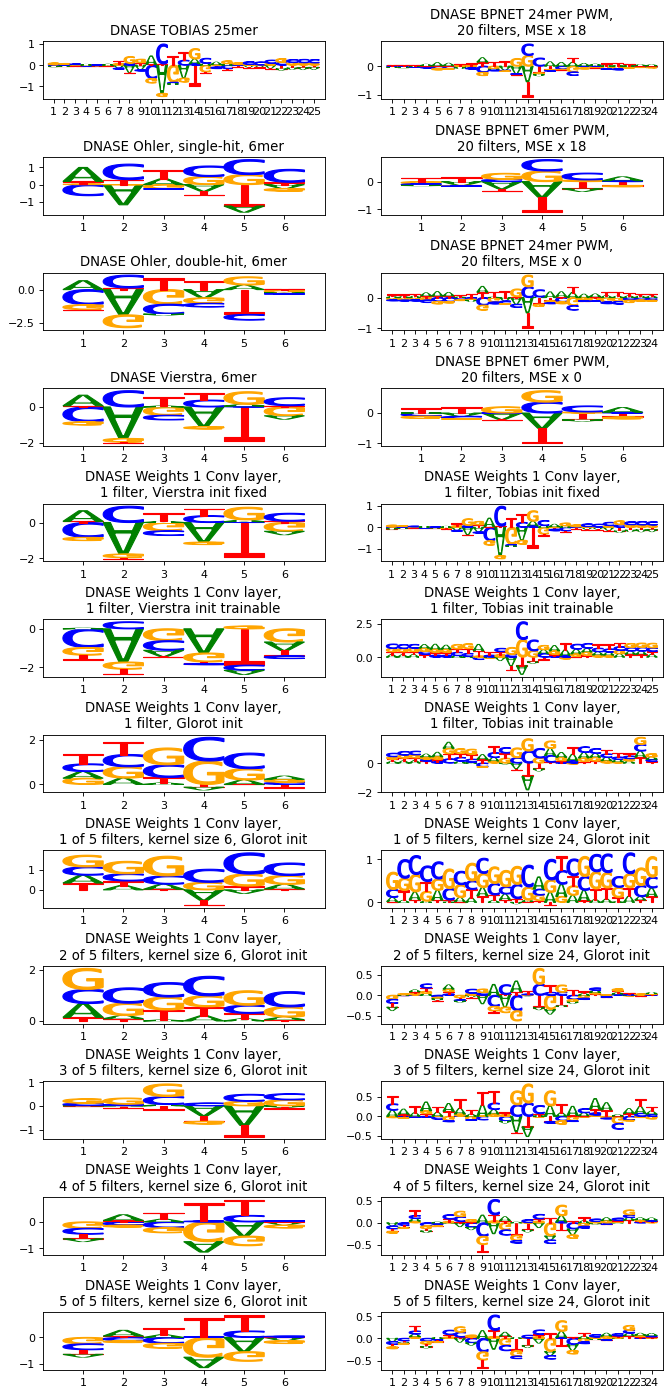

In [130]:
f,axes=plt.subplots(nrows=12,ncols=2,dpi=80,figsize=(10,22))

#plot kmer PWM's 
axes[0,0]=plot_bases_on_ax(tobias_dnase_pssm_forward,axes[0,0],show_ticks=True)
axes[0,0].set_title("DNASE TOBIAS 25mer")
axes[1,0]=plot_bases_on_ax(ohler_dnase_singlehit,axes[1,0],show_ticks=True)
axes[1,0].set_title("DNASE Ohler, single-hit, 6mer")
axes[2,0]=plot_bases_on_ax(ohler_dnase_doublehit,axes[2,0],show_ticks=True)
axes[2,0].set_title("DNASE Ohler, double-hit, 6mer")
axes[3,0]=plot_bases_on_ax(vierstra_dnase,axes[3,0],show_ticks=True)
axes[3,0].set_title("DNASE Vierstra, 6mer")

#bpnet scores 
axes[0,1]=plot_bases_on_ax(dnase_gm12878_bpnet_pssm_24mer,axes[0,1],show_ticks=True) 
axes[0,1].set_title("DNASE BPNET 24mer PWM,\n20 filters, MSE x 18")
axes[1,1]=plot_bases_on_ax(dnase_gm12878_bpnet_pssm_6mer,axes[1,1],show_ticks=True) 
axes[1,1].set_title("DNASE BPNET 6mer PWM,\n20 filters, MSE x 18")
axes[2,1]=plot_bases_on_ax(dnase_gm12878_bpnet_pssm_24mer_zerocounts,axes[2,1],show_ticks=True)
axes[2,1].set_title("DNASE BPNET 24mer PWM,\n20 filters, MSE x 0")
axes[3,1]=plot_bases_on_ax(dnase_gm12878_bpnet_pssm_6mer_zerocounts,axes[3,1],show_ticks=True)
axes[3,1].set_title("DNASE BPNET 6mer PWM,\n20 filters, MSE x 0")

#1 filter, 6 mer
axes[4,0]=plot_bases_on_ax(fixed_6mer_weights,axes[4,0],show_ticks=True) 
axes[4,0].set_title("DNASE Weights 1 Conv layer,\n1 filter, Vierstra init fixed")
axes[5,0]=plot_bases_on_ax(trainable_6mer_weights,axes[5,0],show_ticks=True) 
axes[5,0].set_title("DNASE Weights 1 Conv layer,\n1 filter, Vierstra init trainable")
axes[6,0]=plot_bases_on_ax(random_6mer_weights,axes[6,0],show_ticks=True) 
axes[6,0].set_title("DNASE Weights 1 Conv layer,\n1 filter, Glorot init")

#1 filter, 24 mer 
axes[4,1]=plot_bases_on_ax(fixed_24mer_weights,axes[4,1],show_ticks=True) 
axes[4,1].set_title("DNASE Weights 1 Conv layer,\n1 filter, Tobias init fixed")
axes[5,1]=plot_bases_on_ax(trainable_24mer_weights,axes[5,1],show_ticks=True) 
axes[5,1].set_title("DNASE Weights 1 Conv layer,\n1 filter, Tobias init trainable")
axes[6,1]=plot_bases_on_ax(random_24mer_weights,axes[6,1],show_ticks=True) 
axes[6,1].set_title("DNASE Weights 1 Conv layer,\n1 filter, Tobias init trainable")

#5 filter, 6mer 
axes[7,0]=plot_bases_on_ax(random_6mer_5filter_weights[:,:,1],axes[7,0],show_ticks=True)
axes[7,0].set_title("DNASE Weights 1 Conv layer,\n1 of 5 filters, kernel size 6, Glorot init")
axes[8,0]=plot_bases_on_ax(random_6mer_5filter_weights[:,:,2],axes[8,0],show_ticks=True)
axes[8,0].set_title("DNASE Weights 1 Conv layer,\n2 of 5 filters, kernel size 6, Glorot init")
axes[9,0]=plot_bases_on_ax(random_6mer_5filter_weights[:,:,3],axes[9,0],show_ticks=True)
axes[9,0].set_title("DNASE Weights 1 Conv layer,\n3 of 5 filters, kernel size 6, Glorot init")
axes[10,0]=plot_bases_on_ax(random_6mer_5filter_weights[:,:,4],axes[10,0],show_ticks=True)
axes[10,0].set_title("DNASE Weights 1 Conv layer,\n4 of 5 filters, kernel size 6, Glorot init")
axes[11,0]=plot_bases_on_ax(random_6mer_5filter_weights[:,:,4],axes[11,0],show_ticks=True)
axes[11,0].set_title("DNASE Weights 1 Conv layer,\n5 of 5 filters, kernel size 6, Glorot init")

#5 filter, 24mer 
axes[7,1]=plot_bases_on_ax(random_24mer_5filter_weights[:,:,1],axes[7,1],show_ticks=True)
axes[7,1].set_title("DNASE Weights 1 Conv layer,\n1 of 5 filters, kernel size 24, Glorot init")
axes[8,1]=plot_bases_on_ax(random_24mer_5filter_weights[:,:,2],axes[8,1],show_ticks=True)
axes[8,1].set_title("DNASE Weights 1 Conv layer,\n2 of 5 filters, kernel size 24, Glorot init")
axes[9,1]=plot_bases_on_ax(random_24mer_5filter_weights[:,:,3],axes[9,1],show_ticks=True)
axes[9,1].set_title("DNASE Weights 1 Conv layer,\n3 of 5 filters, kernel size 24, Glorot init")
axes[10,1]=plot_bases_on_ax(random_24mer_5filter_weights[:,:,4],axes[10,1],show_ticks=True)
axes[10,1].set_title("DNASE Weights 1 Conv layer,\n4 of 5 filters, kernel size 24, Glorot init")
axes[11,1]=plot_bases_on_ax(random_24mer_5filter_weights[:,:,4],axes[11,1],show_ticks=True)
axes[11,1].set_title("DNASE Weights 1 Conv layer,\n5 of 5 filters, kernel size 24, Glorot init")
plt.subplots_adjust(hspace=1)
plt.savefig("DNASE.bias.svg",format='svg')

# ATAC 

In [116]:
#TOBIAS PWM 
tobias_data_atac_gm12878=pickle.load(open("/srv/scratch/annashch/bias_correction/enzymatic_bias/tobias/atac/GM12878.merged.filtered_AtacBias.pickle",'rb'))
tobias_atac_pssm=np.transpose(tobias_data_dnase_k562.bias['forward'].pssm[0:4])[:,[0,2,3,1]]

#Ohler PWM 
ohler_atac=np.loadtxt('/srv/scratch/annashch/bias_correction/enzymatic_bias/get_pwm_from_kmer/pwm.SeqBias_ATAC.txt').T


In [117]:
## BPNET-derived PSSM -->  USE GM12878 because we have those peaks in both DNASE & ATAC 

#load pssm
atac_gm12878_bpnet_pssm_6mer=np.transpose(np.loadtxt("/srv/scratch/annashch/bias_correction/enzymatic_bias/get_pwm_from_bpnet/pwm.atac.gm12878.0.computed.6mer.center"))
atac_gm12878_bpnet_pssm_24mer=np.transpose(np.loadtxt("/srv/scratch/annashch/bias_correction/enzymatic_bias/get_pwm_from_bpnet/pwm.atac.gm12878.0.computed.24mer.center"))


In [118]:
#Ohler fixed, 6mer 
atac_fixed_6mer_model=load_model("/srv/scratch/annashch/bias_correction/enzymatic_bias/profile_model_of_bias/fixed_filter/atac/6mer/seed1234/bias.atac.6mer.0.hdf5")
atac_fixed_6mer_weights=atac_fixed_6mer_model.layers[1].get_weights()[0].squeeze()

In [122]:
#Ohler trainable 6mer 
atac_trainable_6mer_model=load_model("/srv/scratch/annashch/bias_correction/enzymatic_bias/profile_model_of_bias/kmer_init_tuned/atac/6mer/seed1234/bias.atac.6mer.0.hdf5")
atac_trainable_6mer_weights=atac_trainable_6mer_model.layers[1].get_weights()[0].squeeze()

In [123]:
# 6mer random, 1 filter 
atac_random_6mer_model=load_model("/srv/scratch/annashch/bias_correction/enzymatic_bias/profile_model_of_bias/6mer/atac/1filter/seed1234/bias.atac.6mer.0.hdf5")
atac_random_6mer_weights=atac_random_6mer_model.layers[1].get_weights()[0].squeeze()

In [124]:
#Tobias fixed, 24mer 
atac_fixed_24mer_model=load_model("/srv/scratch/annashch/bias_correction/enzymatic_bias/profile_model_of_bias/fixed_filter/atac/24mer/seed1234/bias.atac.24mer.0.hdf5")
atac_fixed_24mer_weights=atac_fixed_24mer_model.layers[1].get_weights()[0].squeeze()

In [125]:
#TOBIAS, trainable, 24mer
atac_trainable_24mer_model=load_model("/srv/scratch/annashch/bias_correction/enzymatic_bias/profile_model_of_bias/kmer_init_tuned/atac/24mer/seed2345/bias.atac.24mer.0.hdf5") 
atac_trainable_24mer_weights=atac_trainable_24mer_model.layers[1].get_weights()[0].squeeze()

In [127]:
# 24mer random 1 filter 
atac_random_24mer_model=load_model("/srv/scratch/annashch/bias_correction/enzymatic_bias/profile_model_of_bias/24mer/atac/1filter/seed2345/bias.atac.24mer.0.hdf5")
atac_random_24mer_weights=atac_random_24mer_model.layers[1].get_weights()[0].squeeze()

In [128]:
#6mer random 5 filter
atac_random_6mer_5filter_model=load_model("/srv/scratch/annashch/bias_correction/enzymatic_bias/profile_model_of_bias/6mer/atac/seed1234/bias.atac.6mer.0.hdf5")
atac_random_6mer_5filter_weights=atac_random_6mer_5filter_model.layers[1].get_weights()[0].squeeze() 

In [129]:
#24mer random 5 filter 
atac_random_24mer_5filter_model=load_model("/srv/scratch/annashch/bias_correction/enzymatic_bias/profile_model_of_bias/24mer/atac/seed1234/bias.atac.24mer.0.hdf5")
atac_random_24mer_5filter_weights=atac_random_24mer_5filter_model.layers[1].get_weights()[0].squeeze() 

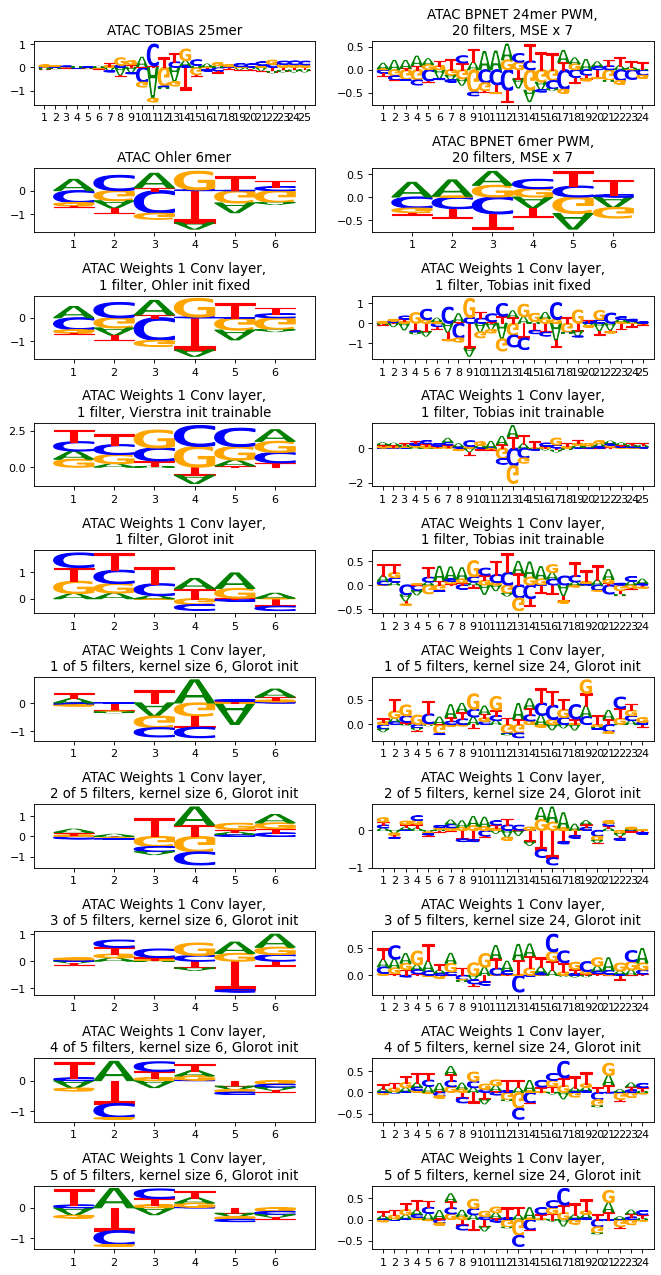

In [132]:
f,axes=plt.subplots(nrows=10,ncols=2,dpi=80,figsize=(10,20))

#plot kmer PWM's 
axes[0,0]=plot_bases_on_ax(tobias_atac_pssm,axes[0,0],show_ticks=True)
axes[0,0].set_title("ATAC TOBIAS 25mer")
axes[1,0]=plot_bases_on_ax(ohler_atac,axes[1,0],show_ticks=True)
axes[1,0].set_title("ATAC Ohler 6mer")

#bpnet scores 
axes[0,1]=plot_bases_on_ax(atac_gm12878_bpnet_pssm_24mer,axes[0,1],show_ticks=True) 
axes[0,1].set_title("ATAC BPNET 24mer PWM,\n20 filters, MSE x 7")
axes[1,1]=plot_bases_on_ax(atac_gm12878_bpnet_pssm_6mer,axes[1,1],show_ticks=True) 
axes[1,1].set_title("ATAC BPNET 6mer PWM,\n20 filters, MSE x 7")

#1 filter, 6 mer
axes[2,0]=plot_bases_on_ax(atac_fixed_6mer_weights,axes[2,0],show_ticks=True) 
axes[2,0].set_title("ATAC Weights 1 Conv layer,\n1 filter, Ohler init fixed")
axes[3,0]=plot_bases_on_ax(atac_trainable_6mer_weights,axes[3,0],show_ticks=True) 
axes[3,0].set_title("ATAC Weights 1 Conv layer,\n1 filter, Vierstra init trainable")
axes[4,0]=plot_bases_on_ax(atac_random_6mer_weights,axes[4,0],show_ticks=True) 
axes[4,0].set_title("ATAC Weights 1 Conv layer,\n1 filter, Glorot init")

#1 filter, 24 mer 
axes[2,1]=plot_bases_on_ax(atac_fixed_24mer_weights,axes[2,1],show_ticks=True) 
axes[2,1].set_title("ATAC Weights 1 Conv layer,\n1 filter, Tobias init fixed")
axes[3,1]=plot_bases_on_ax(atac_trainable_24mer_weights,axes[3,1],show_ticks=True) 
axes[3,1].set_title("ATAC Weights 1 Conv layer,\n1 filter, Tobias init trainable")
axes[4,1]=plot_bases_on_ax(atac_random_24mer_weights,axes[4,1],show_ticks=True) 
axes[4,1].set_title("ATAC Weights 1 Conv layer,\n1 filter, Tobias init trainable")

#5 filter, 6mer 
axes[5,0]=plot_bases_on_ax(atac_random_6mer_5filter_weights[:,:,1],axes[5,0],show_ticks=True)
axes[5,0].set_title("ATAC Weights 1 Conv layer,\n1 of 5 filters, kernel size 6, Glorot init")
axes[6,0]=plot_bases_on_ax(atac_random_6mer_5filter_weights[:,:,2],axes[6,0],show_ticks=True)
axes[6,0].set_title("ATAC Weights 1 Conv layer,\n2 of 5 filters, kernel size 6, Glorot init")
axes[7,0]=plot_bases_on_ax(atac_random_6mer_5filter_weights[:,:,3],axes[7,0],show_ticks=True)
axes[7,0].set_title("ATAC Weights 1 Conv layer,\n3 of 5 filters, kernel size 6, Glorot init")
axes[8,0]=plot_bases_on_ax(atac_random_6mer_5filter_weights[:,:,4],axes[8,0],show_ticks=True)
axes[8,0].set_title("ATAC Weights 1 Conv layer,\n4 of 5 filters, kernel size 6, Glorot init")
axes[9,0]=plot_bases_on_ax(atac_random_6mer_5filter_weights[:,:,4],axes[9,0],show_ticks=True)
axes[9,0].set_title("ATAC Weights 1 Conv layer,\n5 of 5 filters, kernel size 6, Glorot init")

#5 filter, 24mer 
axes[5,1]=plot_bases_on_ax(atac_random_24mer_5filter_weights[:,:,1],axes[5,1],show_ticks=True)
axes[5,1].set_title("ATAC Weights 1 Conv layer,\n1 of 5 filters, kernel size 24, Glorot init")
axes[6,1]=plot_bases_on_ax(atac_random_24mer_5filter_weights[:,:,2],axes[6,1],show_ticks=True)
axes[6,1].set_title("ATAC Weights 1 Conv layer,\n2 of 5 filters, kernel size 24, Glorot init")
axes[7,1]=plot_bases_on_ax(atac_random_24mer_5filter_weights[:,:,3],axes[7,1],show_ticks=True)
axes[7,1].set_title("ATAC Weights 1 Conv layer,\n3 of 5 filters, kernel size 24, Glorot init")
axes[8,1]=plot_bases_on_ax(atac_random_24mer_5filter_weights[:,:,4],axes[8,1],show_ticks=True)
axes[8,1].set_title("ATAC Weights 1 Conv layer,\n4 of 5 filters, kernel size 24, Glorot init")
axes[9,1]=plot_bases_on_ax(atac_random_24mer_5filter_weights[:,:,4],axes[9,1],show_ticks=True)
axes[9,1].set_title("ATAC Weights 1 Conv layer,\n5 of 5 filters, kernel size 24, Glorot init")
plt.subplots_adjust(hspace=1)
plt.savefig("ATAC.bias.svg",format='svg')